In [32]:
# library imports
import serial, time, threading
import numpy as np
import scipy.optimize as so


<IPython.core.display.Javascript object>


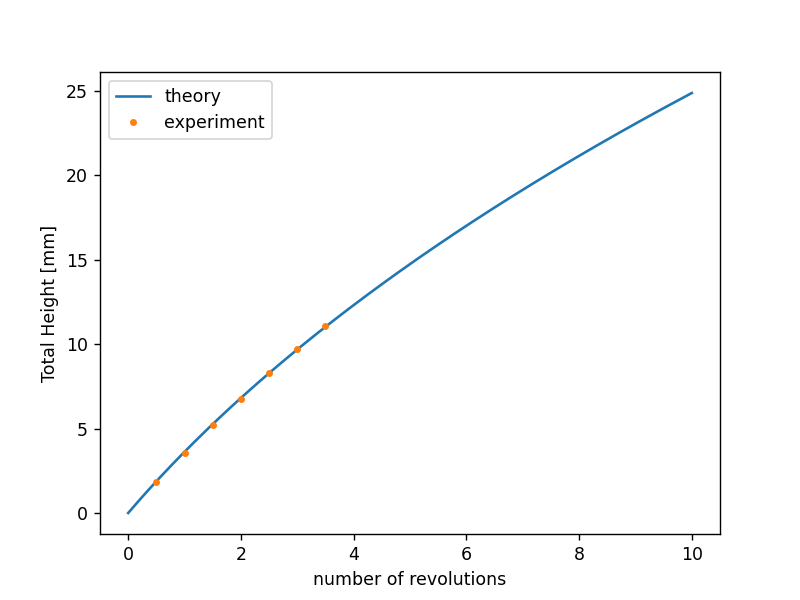

In [31]:
# Getting a rough idea of D,L from the measured points. 

# geometry as shown above
L = 51.1
D = 99
x = np.linspace(0,10,num=500)

# height - it is multiplied by 2 because the sqrt term only calculates the height of the center rotation point.
Tn = np.sqrt(L**2 - ((D-x)/2)**2) * 2 # total height
Tn = Tn - Tn[0]                       # height from the zero point. 

exp_rev = np.array( [0.5,1,1.5,2,2.5,3,3.5] )
exp_stepsize = np.array( [1.832,3.563,5.213,6.773,8.26,9.685,11.048])

plt.figure()
plt.plot(x , Tn ,label = 'theory')
plt.plot(exp_rev,exp_stepsize,'o',label='experiment', markersize = 3)
plt.xlabel('number of revolutions')
plt.ylabel('Total Height [mm]')
plt.legend()


plt.show()

result of optimization: D=113.62 mm, L=58.74 mm


<IPython.core.display.Javascript object>


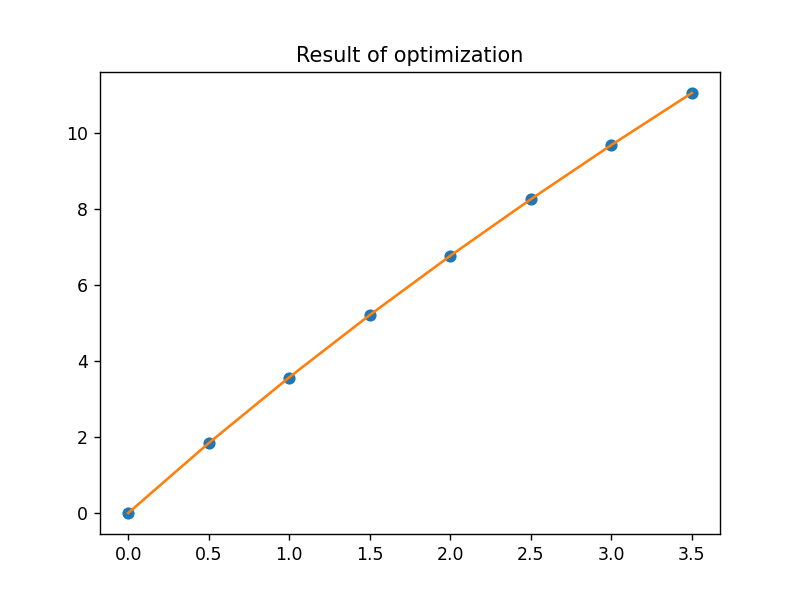

In [33]:
# minimization routine to better find D, L
import scipy.optimize as so


# experimental data
x = np.array( [0,0.5,1,1.5,2,2.5,3,3.5] ) # num revolutions
exp_height = np.array( [0,1.832,3.563,5.213,6.773,8.26,9.685,11.048]) # stage height (starting from 0)

def model_height(D,L,x):
    return ( np.sqrt(L**2 - ((D-x)/2)**2) - np.sqrt(L**2 - (D/2)**2) ) * 2 

def f(args,x,exp_height):
    D = args[0]
    L = args[1]
    
    if D>2*L: # this condition should not physically be possible.
        ret = 100
    else:
        ret = model_height(D,L,x) - exp_height
    
    return ret

res = so.least_squares( f , [99,51.1] , bounds=(0,150),args=(x,exp_height,),jac='3-point')
print(f"result of optimization: D={res.x[0]:.2f} mm, L={res.x[1]:.2f} mm")

plt.figure()
#plt.plot( x , f(res.x,x,exp_height))
plt.plot( x, exp_height,'o')
plt.plot( x, model_height(res.x[0],res.x[1],x))
plt.title('Result of optimization')
plt.show()



To get dH=6 mm, at x=0 mm, then dx=[1.73483681] mm, which is [1.73483681] revolutions, [5551.47778704] steps since 1 rev = 1 mm.


<IPython.core.display.Javascript object>


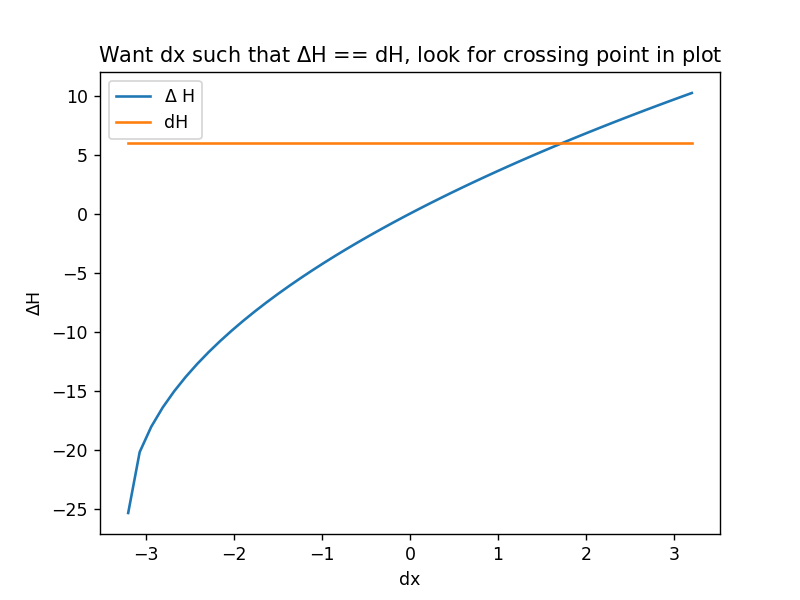

In [34]:
# how to find the number of motor revolutions depending on the height - this depends on the current height, L, and D.
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

# functions from the paper
Ht = lambda x,L,D: 2*np.sqrt( L**2 - ((D-x)/2)**2 )
deltaHt = lambda dx,x,L,D: Ht(x+dx,L,D) - Ht(x,L,D)

# this is a function for the minimization
# notice that the first term (in parenthesis) is deltaHt
# the second term is DH, which is the desired stage height change.
# so, this function is 0 when dx is found such that deltaHt == DH
# then, we can use a numerical root-finding algorithm to find dx
findDXfromDH= lambda dx,DH,x,L,D: ( Ht(x+dx,L,D) - Ht(x,L,D) )  - DH

# parameters
L = 51.1 # [mm]
D = 99 # [mm]
x = 0  # [mm]. corresponds to the current height using Ht, L, D.
dH = 6 # [mm]. this is the desired height change

# now we can use the root finding algorithm to solve findDXfromDH
res = so.root( findDXfromDH , 0 , (dH,x,L,D) )


print(f"To get dH={dH} mm, at x={x} mm, then dx={res.x} mm, which is {res.x} revolutions, {res.x * 3200} steps since 1 rev = 1 mm.")

plt.figure()
X = np.linspace(-(2*L-D),(2*L-D))
plt.plot(X,deltaHt(X,x,L,D),label='$\Delta$ H')
plt.plot(X,dH*np.ones_like(X),label='dH')
plt.xlabel('dx')
plt.ylabel('$\Delta$H')
plt.legend()
plt.title('Want dx such that $\Delta$H == dH, look for crossing point in plot')
plt.show()

## Arduino code for to control the motor controller while monitoring limit switches

In [35]:
# arduino test code
"""
arduino = serial.Serial(port='COM5', baudrate=9600, timeout=.1)

def write_read(x):
    arduino.write(bytes(x, 'utf-8'))
    time.sleep(0.05)
    data = arduino.readline().decode('utf-8')
    return data

while True:
    num = input("Enter a number: ")
    value = write_read(num)
    print(value)
"""

'\narduino = serial.Serial(port=\'COM5\', baudrate=9600, timeout=.1)\n\ndef write_read(x):\n    arduino.write(bytes(x, \'utf-8\'))\n    time.sleep(0.05)\n    data = arduino.readline().decode(\'utf-8\')\n    return data\n\nwhile True:\n    num = input("Enter a number: ")\n    value = write_read(num)\n    print(value)\n'

In [14]:
# z stage independent class

class Z_STAGE:
    def __init__(self):
        
        # z stage serial initialization 
        try:
            self.z_ser = serial.Serial(port='COM5', baudrate=9600, timeout=.1)
        except Exception as e:
            print("Z-stage serial port not opened. The error is:")
            print(e)
        
        # WARNING: these might be wrong if the motor is not homed. 
        # must be defined for move_rel purposes. 
        self.currZ = 0.0 # in mm
        self.currX = 0.0 # in mm
        self.currDir = 1; # 1 = forwards, 0 = backwards
        
        self.stepsPerRev = 3200
                  
    # to be run in the background; prints out all serial output from arduino 
    def serialMonitor(self, evt):

        exitFlag=False
        
        while exitFlag is False:
            line = self.z_ser.readline().decode("utf-8")

            if(line != ''):
                print(line)
            
            # to get rid of remaining distance to go after hitting the limit switch. Extremely crude and hacky. 
            if(line == 'hit lower switch'):
                self.z_ser.close()
                self.z_ser = serial.Serial(port='COM5', baudrate=9600, timeout=.1)

            exitFlag = evt.isSet()
            
    def home_motor(self):
        
        """
        Home the z-stage motor to set the hit limit switch position to 0. 
        NOTICE: Homing sets the position at 1600 steps away from limit switch hit point for more accuracy on lower range. 
        """
        
        self.z_ser.write(bytes('hE', 'utf-8'))
        
        self.currX = 0.0 # in mm
        self.currZ = 0.0 # in mm
        self.currDir = 1; # 1 = forwards, 0 = backwards. the last thing the homing sequence does is move forwards. 
        
    def move_revX(self, revs):
        """
        Moves a specified number of revolutions (1 mm in X = 1 rev = 3200 steps). 
        Use for calibrating. 
                
        """
        steps = revs * 3200
        
        try: 
            stepsStr = str(steps) + 'E'
            self.z_ser.write(bytes(stepsStr, 'utf-8'))
        except Exception as e:
                print('move_revX did not work. the error is:')
                print(e)
                print('the command was: ',stepsStr)       
        
    
    def move_rel(self, dH):
        """
        Moves a specified dH relative to current position. 
        
        TODO: check bounds 
        
        Accepts a float representing mm to move in z. Can't send a number to arduino, so send float number of steps as a string. 
        Arduino will only process relative movements in mm, and will convert to steps itself. Cannot differentiate between 
        relative and absolute, and bounds are not handled other than the lower limit switch. 
        
        not recommended to operate all the way up flush to 0 on the z-stage. 
        """
        # check in bounds
        if self.currZ + dH < 0 or self.currZ + dH > 50:
            print("movement out of bounds. Range of z movement [0,50], current z position is ", self.currZ)
            return
            # TODO: this might not be accurate because difference of around 0.1mm at 6ish, .3 mm at 10ish mm height rn 
        
        # current "position" given by x - this can be converted to a height via H(x) = 2*np.sqrt( L**2 - ((D-x)/2)**2 )
        x = self.currX
        
        # stage parameters
        L = 51.1
        D = 99

        # height change that we seek
        # dH

        #################################
        # define a grid of possible dx points
        # guess bounds based on 0.8mm per revolution (1mm), biggest range possible
        # IMPORTANT: this guessing assumes that the stage will never be operated in a range that has less than 
        # 0.8mm z per 1mm/1rev -- about the last two centimeters of the screw. 
        guess = dH/0.8 
        
        lower = 0
        upper = 0
        
        if dH > 0:
            upper = guess
        elif dH < 0:
            lower = guess
        
        dx = np.linspace(lower,upper, 2000)
        #dx -= dx % 0.0003125 # for a whole number of steps

        # this is dH, i.e. H(x+dx) - H(x)
        dH_c = 2*( np.sqrt(L**2 - ((D-x-dx)/2)**2) - np.sqrt(L**2 - ((D-x)/2)**2) )

        # evaluate dH_f - dH, which we want to be zero
        res = dH_c - dH

        # take the absolute value of res then find the minimum, which will be by the intersection or zero point.
        ind_min = np.argmin( np.abs(res) )

        # find the value of dx that corresponds to it
        dx_opt = dx[ind_min]                           # in mm / rev (1 mm = 1 rev)
        steps = float(dx_opt * self.stepsPerRev)       # in steps (3200 steps per rev)
        
        # FUNCTIONS FOR TESTING
        Ht = lambda x,L,D: 2*np.sqrt( L**2 - ((D-x)/2)**2 )
        deltaHt = lambda dx,x,L,D: Ht(x+dx,L,D) - Ht(x,L,D)
        print("starting at x", self.currX)
        print("moved", str(steps), "steps,", dx_opt, "mm", deltaHt(dx_opt, self.currX, L,D),"mm height")
        
        # check if changing directions to account for backlash
        if dH > 0 and self.currDir == 1 or dH < 0 and self.currDir == 0: 
            print("SAME DIRECTION")
        else:
            print("CHANGING DIRECTION")
            # move an extra 0.1 if going backwards 
        
        # SEND MOVE TO ARDUINO
        self.send_command(steps)
        self.currX += dx_opt
        self.currZ += dH
        print("ending height is", self.currZ)
        
    def move_abs(self, h):
        
        self.move_rel(h - self.currZ)
        
    def send_command(self, steps):
        
        # add end flag and write to arduino
        
        try: 
            stepsStr = str(steps) + 'E'
            self.z_ser.write(bytes(stepsStr, 'utf-8'))
        except Exception as e:
                print('that command did not work. the error is:')
                print(e)
                print('the command was: ',stepsStr)
    
    

# to be integrated into stageCommands in 2D notebook
# need to add z_ser to 2D notebook
def _stageCommands(zstage, evt):

    print('Type <stop>, without brackets, to end serial connection, or <home>, without brackets, to home the Z-stage motor.')

    while 1:
        cmd = input('Enter command: ')
        cmd = cmd.lower()
        
        if cmd == 'stop':
            print('Closing serial port and stopping monitoring.')
            zstage.z_ser.close()
            evt.set()
            break
        elif cmd == 'home':
            zstage.home_motor()
        elif cmd[0:4] == 'z r ' or cmd[0:4] == 'z a ':
            
            #only accept a positive or negative float
            if cmd[4] == '-' and cmd[5:].replace('.','',1).isdigit() or cmd[4:].replace('.','',1).isdigit():
                mmToMoveStr = cmd[4:]
                
                # send command to z stage class
                if cmd[2] == 'r':
                    zstage.move_rel(float(mmToMoveStr))
                elif cmd[2] == 'a': 
                    zstage.move_abs(float(mmToMoveStr))
            else:
                print("Invalid number.")
                continue
                
        elif cmd[0:4] == 'rev ':
            zstage.move_revX(float(cmd[4:]))
        else:
            print("Invalid command. Enter z-stage commands in the format 'z a/r (float)'.")
        

In [15]:
# main
zstage = Z_STAGE()

evt = threading.Event()

serialMonitor = threading.Thread(target=zstage.serialMonitor, args=(evt,))
stageCommands = threading.Thread(target=_stageCommands, args=(zstage, evt,))

serialMonitor.start(); stageCommands.start();

serialMonitor.join(); stageCommands.join();

Type <stop>, without brackets, to end serial connection, or <home>, without brackets, to home the Z-stage motor.
Z Stage Ready.

Enter command: home
received h

homing z-stage.

moving relative steps 128000000

hit lower switch

moving relative steps -3200

moving relative steps 6400

hit lower switch

moving relative steps -1600

homing completed

done

Enter command: z r 6
starting at x 0.0
moved 5546.773386693347 steps, 1.733366683341671 mm 5.9954419769248695 mm height
SAME DIRECTION
ending height is 6.0
received 5546.773386693347

moving relative steps -5546

done

Enter command: home
received h

homing z-stage.

moving relative steps 128000000

hit lower switch

moving relative steps -3200

moving relative steps 6400

hit lower switch

moving relative steps -1600

homing completed

done

Enter command: z a 10
starting at x 0.0
moved 9964.982491245622 steps, 3.114057028514257 mm 9.991601474329642 mm height
SAME DIRECTION
ending height is 10.0
received 9964.982491245622

moving rela

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\kathe\AppData\Local\Programs\Python\Python38\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\kathe\AppData\Local\Programs\Python\Python38\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kathe\AppData\Local\Temp\ipykernel_17160\132664115.py", line 27, in serialMonitor
  File "C:\Users\kathe\AppData\Local\Programs\Python\Python38\lib\site-packages\serial\serialwin32.py", line 287, in read
    raise SerialException("ReadFile failed ({!r})".format(ctypes.WinError()))
serial.serialutil.SerialException: ReadFile failed (OSError(9, 'The handle is invalid.', None, 6))


Closing serial port and stopping monitoring.
